# Численное моделирование распространения сейсмических волн в двумерной среде MILEN SEM 2D

## Часть II: Построение геометрии конечно-элементной сетки

### Задача

Построение деформированной конечно-элементной сетки с адаптацией к геологическим границам.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [2]:
# Глобальный флаг для управления отображением графиков
SHOW_PLOTS = True  # True - показывать графики, False - только сохранять

### 1. Параметры сетки

Базовая сетка 1176×245 узлов с разрешением 10×10 м, адаптированная к геологическим поверхностям.

### 2. Параметры базовой сетки модели

- Размер: 1176×245 узлов (10×10 м)
- Область: 11750×2440 м
- Всего узлов: 288,120 

### 3. Адаптация к геологии

Деформация регулярной сетки в соответствии с топографией 11 геологических поверхностей из файлов `src/Depth_surfaces_for_Fidesys/hrz__*.txt`.

#### 3.1. Геологические поверхности

**Формат файлов `hrz__*.txt`:**
- [индекс_x, индекс_y, координата_x, координата_y, глубина_z]
- 11 поверхностей, ~374k точек каждая


#### 3.2. Загрузка и анализ поверхностей

In [3]:


# Путь к папке с поверхностями
surfaces_path = 'src/Depth_surfaces_for_Fidesys/'

# Найдем все файлы поверхностей
surface_files = glob(os.path.join(surfaces_path, 'hrz__*.txt'))
surface_files.sort()

print(f"Найдено поверхностей: {len(surface_files)}")
print("Список файлов поверхностей:")
for i, file in enumerate(surface_files, 1):
    filename = os.path.basename(file)
    print(f"{i:2d}. {filename}")


Найдено поверхностей: 11
Список файлов поверхностей:
 1. hrz__0_surf_time_depth_itog.txt
 2. hrz__A_time_depth_itog.txt
 3. hrz__B_time_depth_itog.txt
 4. hrz__G1_time_depth_itog.txt
 5. hrz__G2_time_depth_itog.txt
 6. hrz__G_time_depth_itog.txt
 7. hrz__M1_time_depth_itog.txt
 8. hrz__M_time_depth_itog.txt
 9. hrz__U2_time_depth_itog.txt
10. hrz__Under_0_time_depth_itog.txt
11. hrz__Upper_time_depth_itog.txt


In [4]:
# Функция для загрузки данных поверхности
def load_surface_data(filename):
    """
    Загрузка данных поверхности из файла
    Формат: x-индекс, y-индекс, x-координата, y-координата, z-координата (глубина)
    """
    data = np.loadtxt(filename)
    x_indices = data[:, 0].astype(int)
    y_indices = data[:, 1].astype(int) 
    x_coords = data[:, 2]
    y_coords = data[:, 3]
    depths = data[:, 4]
    
    return {
        'x_indices': x_indices,
        'y_indices': y_indices,
        'x_coords': x_coords,
        'y_coords': y_coords,
        'depths': depths,
        'min_depth': np.min(depths),
        'max_depth': np.max(depths),
        'mean_depth': np.mean(depths)
    }

# Загрузим данные всех поверхностей
surfaces_data = {}
print("Загрузка данных поверхностей...")
for file in surface_files:
    surface_name = os.path.basename(file).replace('.txt', '')
    print(f"Загружаем {surface_name}...")
    surfaces_data[surface_name] = load_surface_data(file)
    data = surfaces_data[surface_name]
    print(f"  Точек: {len(data['depths'])}")
    print(f"  Глубина: min={data['min_depth']:.2f}, max={data['max_depth']:.2f}, mean={data['mean_depth']:.2f}")
    print()


Загрузка данных поверхностей...
Загружаем hrz__0_surf_time_depth_itog...
  Точек: 374247
  Глубина: min=0.00, max=0.00, mean=0.00

Загружаем hrz__A_time_depth_itog...
  Точек: 374247
  Глубина: min=2259.50, max=2579.69, mean=2456.88

Загружаем hrz__B_time_depth_itog...
  Точек: 374247
  Глубина: min=2196.24, max=2334.55, mean=2286.06

Загружаем hrz__G1_time_depth_itog...
  Точек: 374247
  Глубина: min=486.40, max=520.90, mean=501.61

Загружаем hrz__G2_time_depth_itog...
  Точек: 374247
  Глубина: min=419.43, max=446.45, mean=429.40

Загружаем hrz__G_time_depth_itog...
  Точек: 374247
  Глубина: min=891.92, max=927.61, mean=907.17

Загружаем hrz__M1_time_depth_itog...
  Точек: 374247
  Глубина: min=1366.56, max=1411.88, mean=1385.77

Загружаем hrz__M_time_depth_itog...
  Точек: 374247
  Глубина: min=1641.97, max=1702.15, mean=1671.89

Загружаем hrz__U2_time_depth_itog...
  Точек: 374247
  Глубина: min=2228.08, max=2380.14, mean=2325.58

Загружаем hrz__Under_0_time_depth_itog...
  Точек:

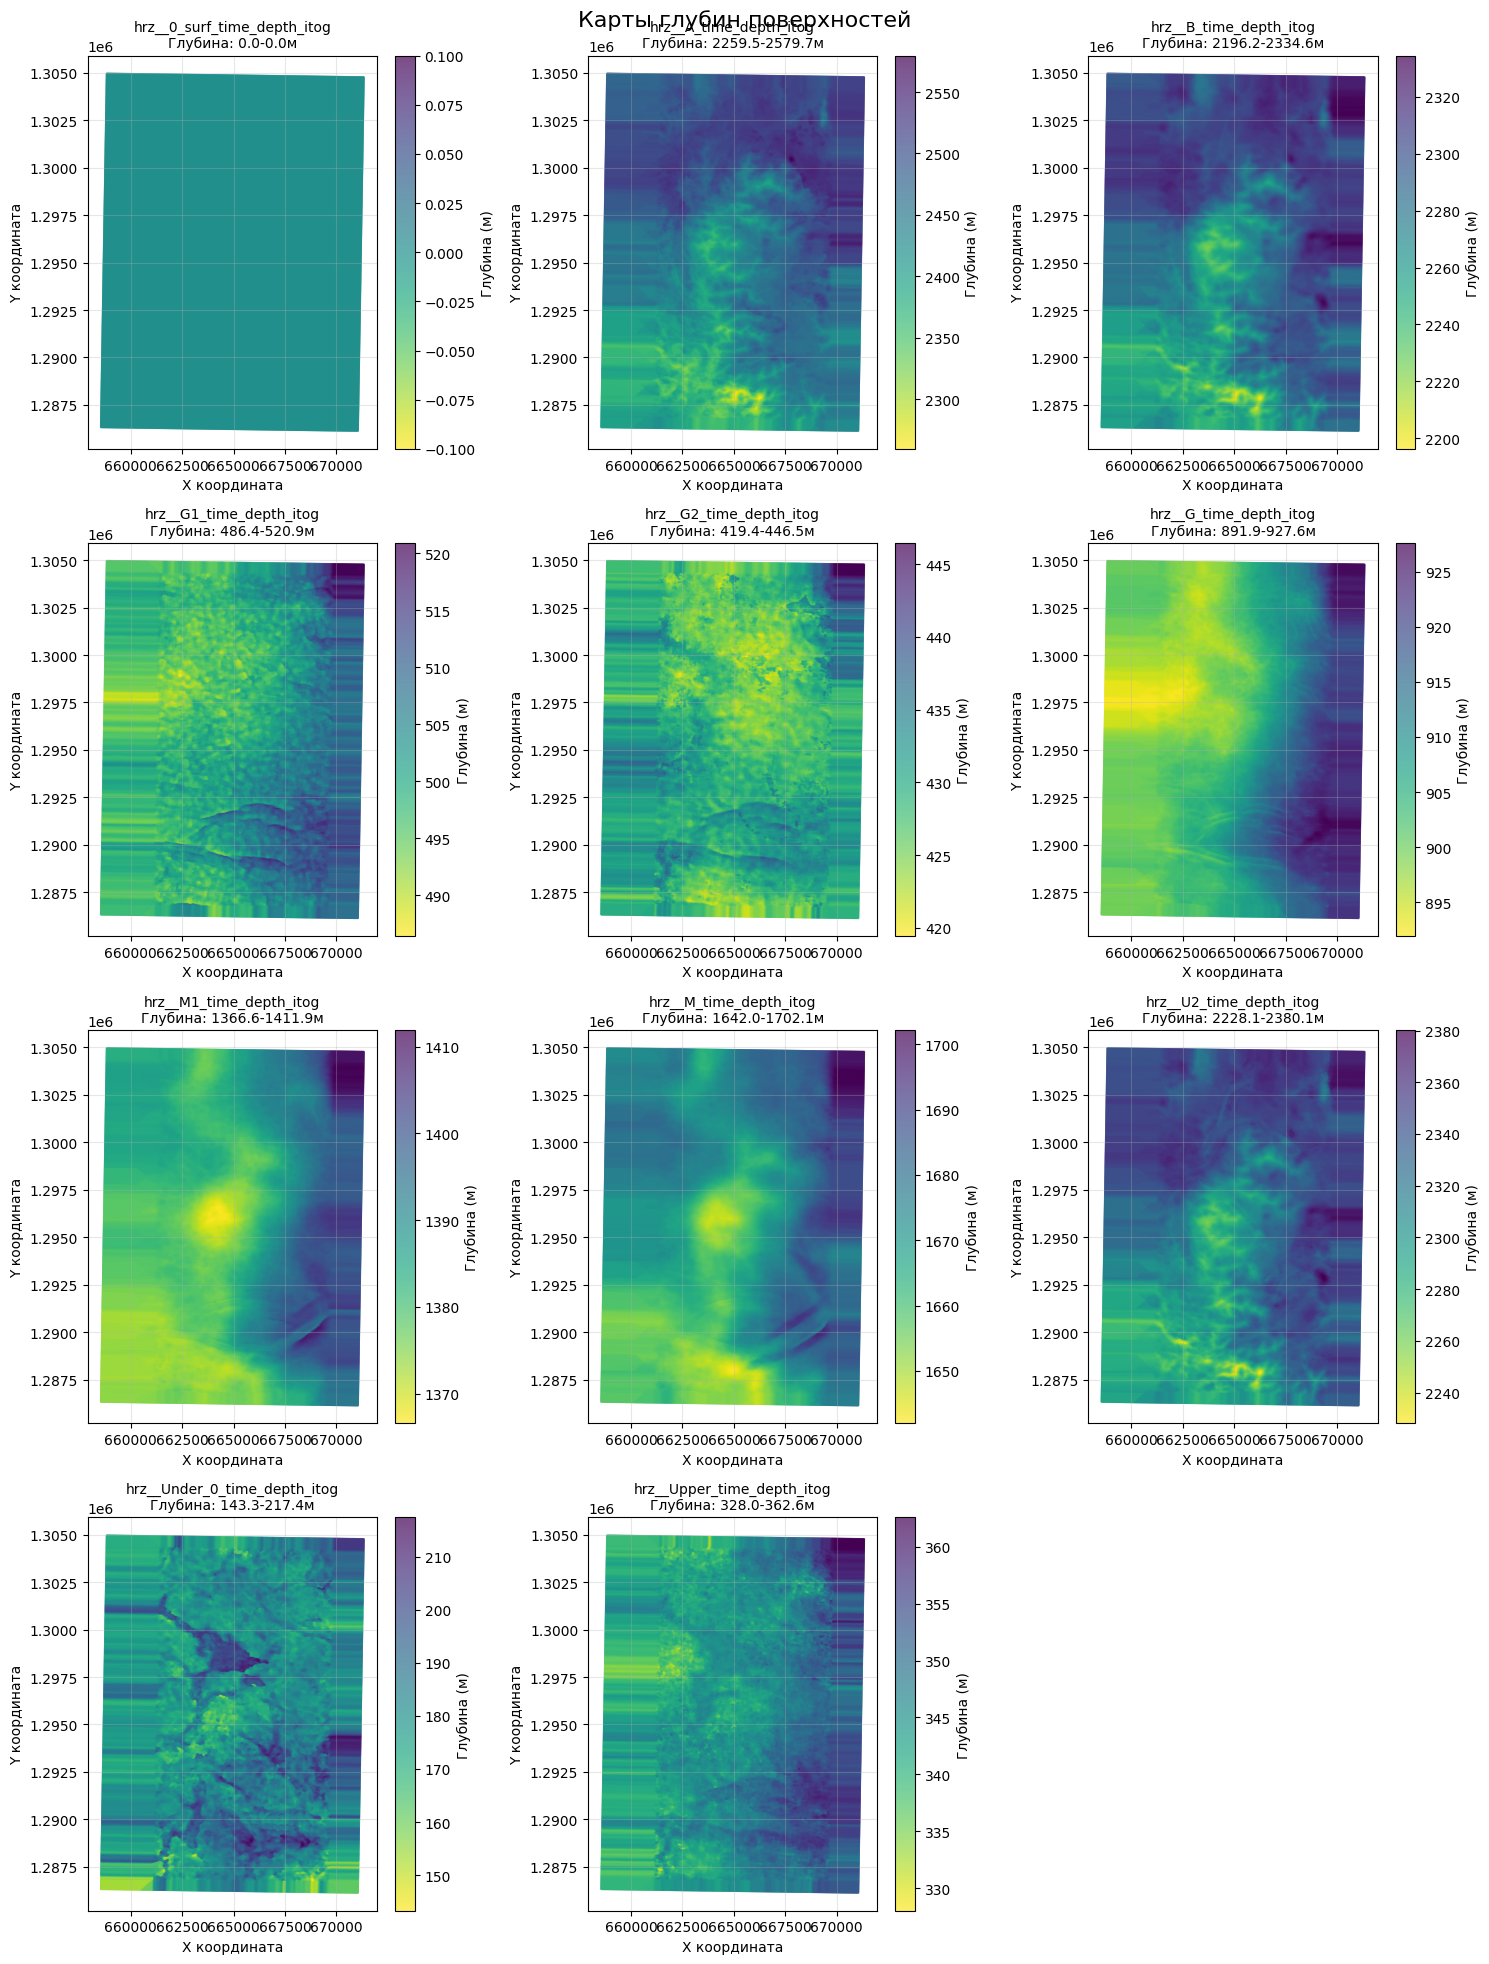

Карты глубин сохранены в файл: depth_maps_all_surfaces.png


In [5]:
# Создание карт глубин для всех поверхностей
def create_depth_maps(surfaces_data):
    """
    Создание карт глубин для всех поверхностей
    """
    n_surfaces = len(surfaces_data)
    
    # Определим размер сетки для subplot
    cols = 3
    rows = (n_surfaces + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    fig.suptitle('Карты глубин поверхностей', fontsize=16)
    
    # Если только одна строка, приведем axes к списку
    if rows == 1:
        axes = [axes] if n_surfaces == 1 else axes
    else:
        axes = axes.flatten()
    
    # Построим карты для каждой поверхности
    for i, (surface_name, data) in enumerate(surfaces_data.items()):
        ax = axes[i]
        
        # Создаем скаттер-плот с цветовой картой глубины
        scatter = ax.scatter(data['x_coords'], data['y_coords'], 
                           c=data['depths'], cmap='viridis_r', 
                           s=0.1, alpha=0.7)
        
        ax.set_title(f'{surface_name}\nГлубина: {data["min_depth"]:.1f}-{data["max_depth"]:.1f}м', 
                    fontsize=10)
        ax.set_xlabel('X координата')
        ax.set_ylabel('Y координата')
        ax.grid(True, alpha=0.3)
        
        # Добавим цветовую шкалу
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Глубина (м)')
    
    # Скроем пустые subplot'ы
    for j in range(n_surfaces, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    
    # Сохраняем изображение вместо показа
    output_filename = 'depth_maps_all_surfaces.png'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    if SHOW_PLOTS:
        plt.show()
    else:
        plt.close()
    print(f"Карты глубин сохранены в файл: {output_filename}")

# Создаем карты глубин
create_depth_maps(surfaces_data)


In [6]:
# Итоговая информация о поверхностях
print("="*80)
print(f"ИТОГОВАЯ ИНФОРМАЦИЯ О ПОВЕРХНОСТЯХ")
print("="*80)
print(f"Общее количество поверхностей: {len(surfaces_data)}")
print("\nДетальная информация по каждой поверхности:")
print("-"*80)

# Отсортируем поверхности по средней глубине
sorted_surfaces = sorted(surfaces_data.items(), key=lambda x: x[1]['mean_depth'])

for i, (surface_name, data) in enumerate(sorted_surfaces, 1):
    print(f"{i:2d}. {surface_name}")
    print(f"    Количество точек: {len(data['depths']):,}")
    print(f"    Диапазон глубин: {data['min_depth']:.2f} - {data['max_depth']:.2f} м")
    print(f"    Средняя глубина: {data['mean_depth']:.2f} м")
    print(f"    Диапазон X: {np.min(data['x_coords']):.2f} - {np.max(data['x_coords']):.2f}")
    print(f"    Диапазон Y: {np.min(data['y_coords']):.2f} - {np.max(data['y_coords']):.2f}")
    print()

print("="*80)


ИТОГОВАЯ ИНФОРМАЦИЯ О ПОВЕРХНОСТЯХ
Общее количество поверхностей: 11

Детальная информация по каждой поверхности:
--------------------------------------------------------------------------------
 1. hrz__0_surf_time_depth_itog
    Количество точек: 374,247
    Диапазон глубин: 0.00 - 0.00 м
    Средняя глубина: 0.00 м
    Диапазон X: 658549.13 - 671331.56
    Диапазон Y: 1286127.50 - 1304965.60

 2. hrz__Under_0_time_depth_itog
    Количество точек: 374,247
    Диапазон глубин: 143.28 - 217.40 м
    Средняя глубина: 181.36 м
    Диапазон X: 658549.13 - 671331.56
    Диапазон Y: 1286127.50 - 1304965.60

 3. hrz__Upper_time_depth_itog
    Количество точек: 374,247
    Диапазон глубин: 328.00 - 362.59 м
    Средняя глубина: 346.15 м
    Диапазон X: 658549.13 - 671331.56
    Диапазон Y: 1286127.50 - 1304965.60

 4. hrz__G2_time_depth_itog
    Количество точек: 374,247
    Диапазон глубин: 419.43 - 446.45 м
    Средняя глубина: 429.40 м
    Диапазон X: 658549.13 - 671331.56
    Диапазон Y: 

### 4. Профиль моделирования

#### 4.1. Координаты скважин

**Файл:** `src/Координаты скважин.txt`
**Параметры:**
- Профиль: вертикальная плоскость через скважины
- Расстояние между скважинами: ~3215.5 м → 3250 м (коррекция)
- Боковое расширение: 4250 м в каждую сторону
- Размеры: 11750×2440 м 


#### 4.2. Коррекция расстояния

Приведение к точному расстоянию 3250 м:
1. Центральная точка между скважинами
2. Симметричное перемещение вдоль направления 

In [7]:
# Загрузка координат скважин
def load_well_coordinates(filename):
    """
    Загружает координаты скважин из файла
    """
    wells = {}
    with open(filename, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    well_num = None
    for line in lines:
        line = line.strip()
        if line.startswith('Well'):
            well_num = int(line.split()[1])
        elif line.startswith('X') and well_num is not None:
            # Парсим строку вида "X  662950  Y  1298623"
            parts = line.replace('X', '').replace('Y', '').split()
            x = float(parts[0])
            y = float(parts[1])
            wells[well_num] = {'x': x, 'y': y}
    
    return wells

# Загружаем координаты скважин
well_coords_file = 'src/Координаты скважин.txt'
wells = load_well_coordinates(well_coords_file)

print("Исходные координаты скважин:")
for well_num, coords in wells.items():
    print(f"Скважина {well_num}: X = {coords['x']:.2f}, Y = {coords['y']:.2f}")

# Вычисляем текущее расстояние между скважинами
well1 = wells[1]
well2 = wells[2]

current_distance = np.sqrt((well2['x'] - well1['x'])**2 + (well2['y'] - well1['y'])**2)
print(f"\nТекущее расстояние между скважинами: {current_distance:.2f} м")


Исходные координаты скважин:
Скважина 1: X = 662950.30, Y = 1298623.50
Скважина 2: X = 664256.00, Y = 1295685.00

Текущее расстояние между скважинами: 3215.53 м


In [8]:
# Пересчет координат скважин для получения точного расстояния 3250 м
target_distance = 3250.0  # целевое расстояние в метрах

# Находим среднюю точку между скважинами
center_x = (well1['x'] + well2['x']) / 2
center_y = (well1['y'] + well2['y']) / 2

print(f"Средняя точка между скважинами: X = {center_x:.2f}, Y = {center_y:.2f}")

# Вычисляем направление от скважины 1 к скважине 2
dx = well2['x'] - well1['x']
dy = well2['y'] - well1['y']

# Нормализуем вектор направления
direction_length = np.sqrt(dx**2 + dy**2)
unit_dx = dx / direction_length
unit_dy = dy / direction_length

print(f"Единичный вектор направления: ({unit_dx:.6f}, {unit_dy:.6f})")

# Пересчитываем координаты скважин относительно центральной точки
# Каждая скважина должна быть на расстоянии target_distance/2 от центра
half_distance = target_distance / 2

# Новые координаты
new_well1_x = center_x - half_distance * unit_dx
new_well1_y = center_y - half_distance * unit_dy

new_well2_x = center_x + half_distance * unit_dx  
new_well2_y = center_y + half_distance * unit_dy

# Обновляем координаты в словаре
wells_adjusted = {
    1: {'x': new_well1_x, 'y': new_well1_y},
    2: {'x': new_well2_x, 'y': new_well2_y}
}

# Проверяем новое расстояние
new_distance = np.sqrt((new_well2_x - new_well1_x)**2 + (new_well2_y - new_well1_y)**2)

print(f"\nНОВЫЕ КООРДИНАТЫ СКВАЖИН:")
print(f"Скважина 1: X = {new_well1_x:.2f}, Y = {new_well1_y:.2f}")
print(f"Скважина 2: X = {new_well2_x:.2f}, Y = {new_well2_y:.2f}")
print(f"Новое расстояние между скважинами: {new_distance:.2f} м")
print(f"Разность с целевым расстоянием: {abs(new_distance - target_distance):.6f} м")


Средняя точка между скважинами: X = 663603.15, Y = 1297154.25
Единичный вектор направления: (0.406061, -0.913846)

НОВЫЕ КООРДИНАТЫ СКВАЖИН:
Скважина 1: X = 662943.30, Y = 1298639.25
Скважина 2: X = 664263.00, Y = 1295669.25
Новое расстояние между скважинами: 3250.00 м
Разность с целевым расстоянием: 0.000000 м


In [9]:
# Сравнение исходных и скорректированных координат
print("="*80)
print("СРАВНЕНИЕ КООРДИНАТ СКВАЖИН")
print("="*80)

print(f"{'Параметр':<25} {'Исходные':<20} {'Скорректированные':<20} {'Изменение':<15}")
print("-" * 80)

for well_num in [1, 2]:
    orig = wells[well_num]
    adj = wells_adjusted[well_num]
    
    dx_change = adj['x'] - orig['x']
    dy_change = adj['y'] - orig['y']
    
    print(f"Скважина {well_num} X (м)     {orig['x']:<20.2f} {adj['x']:<20.2f} {dx_change:+.2f}")
    print(f"Скважина {well_num} Y (м)     {orig['y']:<20.2f} {adj['y']:<20.2f} {dy_change:+.2f}")
    print()

print(f"{'Расстояние между скважинами':<25} {current_distance:<20.2f} {new_distance:<20.2f} {new_distance-current_distance:+.2f}")
print(f"{'Целевое расстояние':<25} {'-':<20} {target_distance:<20.2f} {'-':<15}")

# Сохраним скорректированные координаты для дальнейшего использования
wells_final = wells_adjusted.copy()
print("\n" + "="*80)
print("ИТОГОВЫЕ КООРДИНАТЫ СКВАЖИН ДЛЯ ДАЛЬНЕЙШЕГО МОДЕЛИРОВАНИЯ:")
print("="*80)
print(f"Скважина 1: X = {wells_final[1]['x']:.2f} м, Y = {wells_final[1]['y']:.2f} м")
print(f"Скважина 2: X = {wells_final[2]['x']:.2f} м, Y = {wells_final[2]['y']:.2f} м")
print(f"Расстояние между скважинами: {new_distance:.2f} м (целевое: {target_distance:.2f} м)")
print("="*80)


СРАВНЕНИЕ КООРДИНАТ СКВАЖИН
Параметр                  Исходные             Скорректированные    Изменение      
--------------------------------------------------------------------------------
Скважина 1 X (м)     662950.30            662943.30            -7.00
Скважина 1 Y (м)     1298623.50           1298639.25           +15.75

Скважина 2 X (м)     664256.00            664263.00            +7.00
Скважина 2 Y (м)     1295685.00           1295669.25           -15.75

Расстояние между скважинами 3215.53              3250.00              +34.47
Целевое расстояние        -                    3250.00              -              

ИТОГОВЫЕ КООРДИНАТЫ СКВАЖИН ДЛЯ ДАЛЬНЕЙШЕГО МОДЕЛИРОВАНИЯ:
Скважина 1: X = 662943.30 м, Y = 1298639.25 м
Скважина 2: X = 664263.00 м, Y = 1295669.25 м
Расстояние между скважинами: 3250.00 м (целевое: 3250.00 м)


### 5. Профильные сечения поверхностей

#### 5.1. Параметры

- Длина: 11750 м
- Шаг: 10 м
- Точки: 1176
- Поверхности: 11

Результат: массив [1176×11] с глубинами сечений.

#### 5.2. Алгоритм

- Интерполяция поверхностей в плоскости профиля
- Метод: линейная + ближайшие соседи для пустот
- Выход: NPZ массив + графики

In [10]:
# Создание линии профиля для сечения поверхностей
from scipy.interpolate import griddata

def create_profile_line(wells_final, extension_length=4250):
    """
    Создает линию профиля через две скважины с расширением в обе стороны
    
    Параметры:
    wells_final: словарь с координатами скважин
    extension_length: длина расширения профиля в каждую сторону (м)
    """
    well1 = wells_final[1]
    well2 = wells_final[2]
    
    # Направление от скважины 1 к скважине 2
    dx = well2['x'] - well1['x']
    dy = well2['y'] - well1['y']
    
    # Единичный вектор направления
    length = np.sqrt(dx**2 + dy**2)
    unit_dx = dx / length
    unit_dy = dy / length
    
    # Расширяем линию на extension_length в обе стороны
    # Начальная точка профиля (слева от скважины 1)
    start_x = well1['x'] - extension_length * unit_dx
    start_y = well1['y'] - extension_length * unit_dy
    
    # Конечная точка профиля (справа от скважины 2)
    end_x = well2['x'] + extension_length * unit_dx
    end_y = well2['y'] + extension_length * unit_dy
    
    # Общая длина профиля
    total_length = 2 * extension_length + length
    
    return {
        'start_x': start_x, 'start_y': start_y,
        'end_x': end_x, 'end_y': end_y,
        'unit_dx': unit_dx, 'unit_dy': unit_dy,
        'total_length': total_length,
        'well1_distance_from_start': extension_length,
        'well2_distance_from_start': extension_length + length
    }

# Создаем профиль
profile = create_profile_line(wells_final)

print("ПАРАМЕТРЫ ПРОФИЛЯ:")
print(f"Начало профиля: X = {profile['start_x']:.2f}, Y = {profile['start_y']:.2f}")
print(f"Конец профиля: X = {profile['end_x']:.2f}, Y = {profile['end_y']:.2f}")
print(f"Общая длина профиля: {profile['total_length']:.2f} м")
print(f"Скважина 1 находится на расстоянии {profile['well1_distance_from_start']:.0f} м от начала профиля")
print(f"Скважина 2 находится на расстоянии {profile['well2_distance_from_start']:.0f} м от начала профиля")


ПАРАМЕТРЫ ПРОФИЛЯ:
Начало профиля: X = 661217.54, Y = 1302523.10
Конец профиля: X = 665988.76, Y = 1291785.40
Общая длина профиля: 11750.00 м
Скважина 1 находится на расстоянии 4250 м от начала профиля
Скважина 2 находится на расстоянии 7500 м от начала профиля


In [11]:
# Создание сетки интерполяции вдоль профиля
def create_profile_grid(profile, step=10):
    """
    Создает регулярную сетку точек вдоль профиля с заданным шагом
    """
    # Количество точек
    n_points = int(profile['total_length'] / step) + 1
    
    # Расстояния вдоль профиля
    distances = np.linspace(0, profile['total_length'], n_points)
    
    # Координаты точек вдоль профиля
    profile_x = profile['start_x'] + distances * profile['unit_dx']
    profile_y = profile['start_y'] + distances * profile['unit_dy']
    
    return {
        'distances': distances,
        'x_coords': profile_x,
        'y_coords': profile_y,
        'n_points': n_points
    }

# Создаем сетку с шагом 10м
profile_grid = create_profile_grid(profile, step=10)

print(f"Создана сетка интерполяции:")
print(f"Количество точек: {profile_grid['n_points']}")
print(f"Шаг: 10 м")
print(f"Общая длина: {profile['total_length']:.0f} м")
print(f"Первая точка: X = {profile_grid['x_coords'][0]:.2f}, Y = {profile_grid['y_coords'][0]:.2f}")
print(f"Последняя точка: X = {profile_grid['x_coords'][-1]:.2f}, Y = {profile_grid['y_coords'][-1]:.2f}")

# Проверим, что получили нужное количество точек
expected_points = int(11750 / 10) + 1
print(f"Ожидалось точек: {expected_points}, получено: {profile_grid['n_points']}")


Создана сетка интерполяции:
Количество точек: 1176
Шаг: 10 м
Общая длина: 11750 м
Первая точка: X = 661217.54, Y = 1302523.10
Последняя точка: X = 665988.76, Y = 1291785.40
Ожидалось точек: 1176, получено: 1176


In [12]:
# Интерполяция глубин всех поверхностей вдоль профиля
def interpolate_surface_along_profile(surface_data, profile_x, profile_y):
    """
    Интерполирует глубины поверхности вдоль профиля
    """
    # Координаты точек поверхности
    surface_points = np.column_stack((surface_data['x_coords'], surface_data['y_coords']))
    surface_depths = surface_data['depths']
    
    # Точки профиля для интерполяции
    profile_points = np.column_stack((profile_x, profile_y))
    
    # Интерполяция методом ближайших соседей (более надежный для больших датасетов)
    try:
        interpolated_depths = griddata(surface_points, surface_depths, profile_points, method='linear', fill_value=np.nan)
        
        # Если есть NaN значения, заполняем их методом ближайших соседей
        if np.any(np.isnan(interpolated_depths)):
            nan_mask = np.isnan(interpolated_depths)
            interpolated_depths[nan_mask] = griddata(surface_points, surface_depths, profile_points[nan_mask], method='nearest')
    
    except Exception as e:
        print(f"Ошибка при линейной интерполяции: {e}")
        # Fallback к методу ближайших соседей
        interpolated_depths = griddata(surface_points, surface_depths, profile_points, method='nearest')
    
    return interpolated_depths

# Интерполируем все поверхности
print("Интерполяция глубин поверхностей вдоль профиля...")
profile_depths = {}
n_points = profile_grid['n_points']

# Создаем массив для хранения всех профилей глубин [n_points x n_surfaces]
all_profiles = np.zeros((n_points, len(surfaces_data)))

surface_names = sorted(surfaces_data.keys())
print(f"Обработка {len(surface_names)} поверхностей...")

for i, surface_name in enumerate(surface_names):
    print(f"  {i+1:2d}. Интерполяция {surface_name}...", end=" ")
    
    interpolated_depths = interpolate_surface_along_profile(
        surfaces_data[surface_name],
        profile_grid['x_coords'],
        profile_grid['y_coords']
    )
    
    profile_depths[surface_name] = interpolated_depths
    all_profiles[:, i] = interpolated_depths
    
    print(f"Глубина: {np.min(interpolated_depths):.1f} - {np.max(interpolated_depths):.1f} м")

print(f"\nИнтерполяция завершена!")
print(f"Размер итогового массива: {all_profiles.shape} (точки x поверхности)")


Интерполяция глубин поверхностей вдоль профиля...
Обработка 11 поверхностей...
   1. Интерполяция hrz__0_surf_time_depth_itog... Глубина: 0.0 - 0.0 м
   2. Интерполяция hrz__A_time_depth_itog... Глубина: 2357.4 - 2528.5 м
   3. Интерполяция hrz__B_time_depth_itog... Глубина: 2233.1 - 2317.7 м
   4. Интерполяция hrz__G1_time_depth_itog... Глубина: 488.8 - 513.0 м
   5. Интерполяция hrz__G2_time_depth_itog... Глубина: 423.0 - 434.9 м
   6. Интерполяция hrz__G_time_depth_itog... Глубина: 893.0 - 911.9 м
   7. Интерполяция hrz__M1_time_depth_itog... Глубина: 1367.2 - 1389.3 м
   8. Интерполяция hrz__M_time_depth_itog... Глубина: 1647.1 - 1681.0 м
   9. Интерполяция hrz__U2_time_depth_itog... Глубина: 2267.4 - 2359.4 м
  10. Интерполяция hrz__Under_0_time_depth_itog... Глубина: 156.0 - 201.9 м
  11. Интерполяция hrz__Upper_time_depth_itog... Глубина: 335.5 - 350.2 м

Интерполяция завершена!
Размер итогового массива: (1176, 11) (точки x поверхности)


In [13]:
# Сохранение данных сечений в npz файл
def save_profile_sections_data(all_profiles, profile_depths, profile_grid, surface_names, wells_final, profile):
    """
    Сохраняет данные сечений поверхностей в npz файл
    """
    # Подготавливаем данные для сохранения
    save_data = {
        'profile_depths': all_profiles,  # Основной массив [1176 x 11]
        'distances': profile_grid['distances'],  # Расстояния вдоль профиля
        'profile_x_coords': profile_grid['x_coords'],  # X координаты точек профиля
        'profile_y_coords': profile_grid['y_coords'],  # Y координаты точек профиля  
        'surface_names': surface_names,  # Названия поверхностей
        'well1_coords': [wells_final[1]['x'], wells_final[1]['y']],  # Координаты скважины 1
        'well2_coords': [wells_final[2]['x'], wells_final[2]['y']],  # Координаты скважины 2
        'well1_profile_distance': profile['well1_distance_from_start'],  # Позиция скважины 1 на профиле
        'well2_profile_distance': profile['well2_distance_from_start'],  # Позиция скважины 2 на профиле
        'profile_total_length': profile['total_length'],  # Общая длина профиля
        'profile_start_coords': [profile['start_x'], profile['start_y']],  # Начало профиля
        'profile_end_coords': [profile['end_x'], profile['end_y']]  # Конец профиля
    }
    
    # Сохраняем файл
    output_filename = 'profile_sections_depths.npz'
    np.savez_compressed(output_filename, **save_data)
    
    return output_filename, save_data

# Сохраняем данные
npz_file, saved_data = save_profile_sections_data(all_profiles, profile_depths, profile_grid, surface_names, wells_final, profile)

print("="*80)
print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ ПОСТРОЕНИЯ СЕЧЕНИЙ ПОВЕРХНОСТЕЙ")
print("="*80)
print(f"Количество поверхностей: {len(surface_names)}")
print(f"Количество точек профиля: {profile_grid['n_points']}")
print(f"Шаг дискретизации: 10 м")
print(f"Общая длина профиля: {profile['total_length']:.0f} м")
print(f"Размер основного массива глубин: {all_profiles.shape} (точки × поверхности)")
print()
print("ФАЙЛЫ РЕЗУЛЬТАТОВ:")
print(f"- Данные NPZ: {npz_file}")
print()
print("ПОВЕРХНОСТИ (по средней глубине):")
for i, name in enumerate(surface_names):
    mean_depth = np.mean(all_profiles[:, i])
    min_depth = np.min(all_profiles[:, i])
    max_depth = np.max(all_profiles[:, i])
    print(f"{i+1:2d}. {name}: {min_depth:.1f} - {max_depth:.1f} м (средн. {mean_depth:.1f} м)")
print("="*80)


ИТОГОВЫЕ РЕЗУЛЬТАТЫ ПОСТРОЕНИЯ СЕЧЕНИЙ ПОВЕРХНОСТЕЙ
Количество поверхностей: 11
Количество точек профиля: 1176
Шаг дискретизации: 10 м
Общая длина профиля: 11750 м
Размер основного массива глубин: (1176, 11) (точки × поверхности)

ФАЙЛЫ РЕЗУЛЬТАТОВ:
- Данные NPZ: profile_sections_depths.npz

ПОВЕРХНОСТИ (по средней глубине):
 1. hrz__0_surf_time_depth_itog: 0.0 - 0.0 м (средн. 0.0 м)
 2. hrz__A_time_depth_itog: 2357.4 - 2528.5 м (средн. 2457.3 м)
 3. hrz__B_time_depth_itog: 2233.1 - 2317.7 м (средн. 2282.3 м)
 4. hrz__G1_time_depth_itog: 488.8 - 513.0 м (средн. 498.0 м)
 5. hrz__G2_time_depth_itog: 423.0 - 434.9 м (средн. 428.6 м)
 6. hrz__G_time_depth_itog: 893.0 - 911.9 м (средн. 899.7 м)
 7. hrz__M1_time_depth_itog: 1367.2 - 1389.3 м (средн. 1380.1 м)
 8. hrz__M_time_depth_itog: 1647.1 - 1681.0 м (средн. 1667.0 м)
 9. hrz__U2_time_depth_itog: 2267.4 - 2359.4 м (средн. 2320.5 м)
10. hrz__Under_0_time_depth_itog: 156.0 - 201.9 м (средн. 179.4 м)
11. hrz__Upper_time_depth_itog: 335.5 -

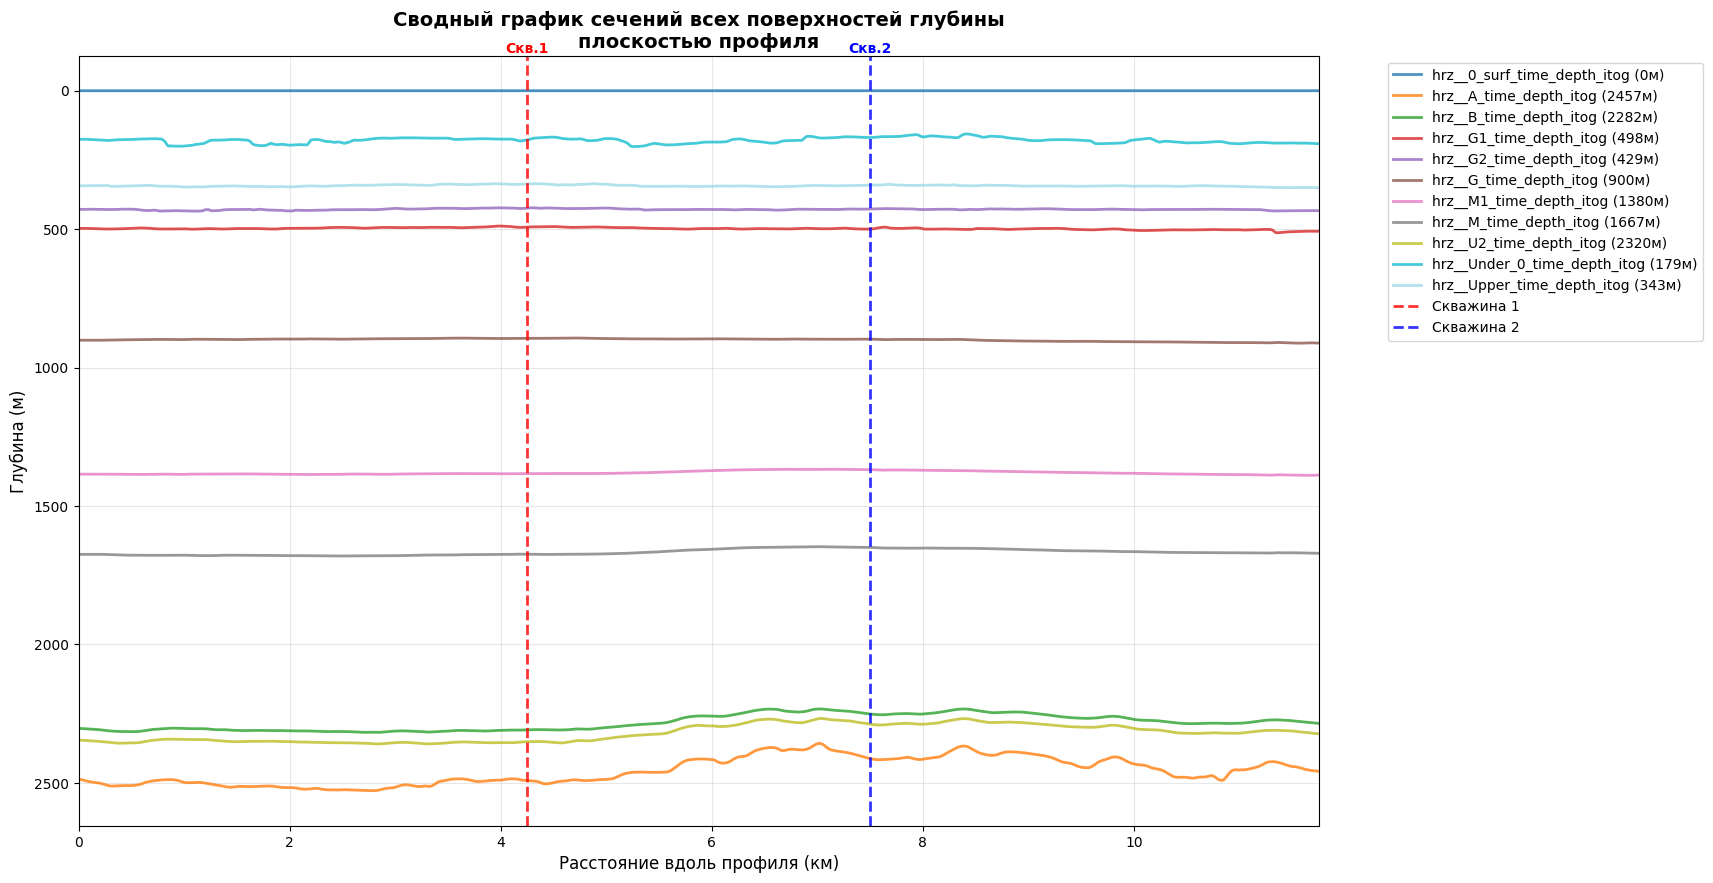

Сводный график всех сечений сохранен в файл: profile_sections_combined.png

СТАТИСТИКА ГЛУБИН ПО ПОВЕРХНОСТЯМ:
----------------------------------------------------------------------
Поверхность                    Мин.     Макс.    Средн.   Размах  
----------------------------------------------------------------------
hrz__0_surf_time_depth_itog    0.0      0.0      0.0      0.0     
hrz__A_time_depth_itog         2357.4   2528.5   2457.3   171.1   
hrz__B_time_depth_itog         2233.1   2317.7   2282.3   84.6    
hrz__G1_time_depth_itog        488.8    513.0    498.0    24.2    
hrz__G2_time_depth_itog        423.0    434.9    428.6    11.9    
hrz__G_time_depth_itog         893.0    911.9    899.7    18.8    
hrz__M1_time_depth_itog        1367.2   1389.3   1380.1   22.1    
hrz__M_time_depth_itog         1647.1   1681.0   1667.0   33.9    
hrz__U2_time_depth_itog        2267.4   2359.4   2320.5   92.1    
hrz__Under_0_time_depth_itog   156.0    201.9    179.4    45.9    
hrz__Upper

In [14]:
# Построение сводного графика со всеми сечениями поверхностей
def plot_all_profiles_combined(profile_depths, profile_grid, wells_final, profile):
    """
    Строит все сечения поверхностей на одном графике для сравнения
    """
    # Расстояния вдоль профиля в км
    distances_km = profile_grid['distances'] / 1000
    
    # Создаем большую фигуру
    plt.figure(figsize=(16, 10))
    
    # Цвета для всех поверхностей
    colors = plt.cm.tab20(np.linspace(0, 1, len(profile_depths)))
    
    # Позиции скважин на профиле (в км)
    well1_pos_km = profile['well1_distance_from_start'] / 1000
    well2_pos_km = profile['well2_distance_from_start'] / 1000
    
    # Строим все поверхности
    legend_elements = []
    for i, (surface_name, depths) in enumerate(profile_depths.items()):
        # Основная линия
        line = plt.plot(distances_km, depths, color=colors[i], linewidth=2, 
                       label=f'{surface_name} ({np.mean(depths):.0f}м)', alpha=0.8)
        legend_elements.append(line[0])
    
    # Отмечаем позиции скважин
    plt.axvline(x=well1_pos_km, color='red', linestyle='--', linewidth=2, 
                alpha=0.8, label='Скважина 1')
    plt.axvline(x=well2_pos_km, color='blue', linestyle='--', linewidth=2, 
                alpha=0.8, label='Скважина 2')
    
    # Добавляем текстовые метки скважин
    plt.text(well1_pos_km, plt.gca().get_ylim()[0], 'Скв.1', 
             ha='center', va='bottom', fontsize=10, color='red', weight='bold')
    plt.text(well2_pos_km, plt.gca().get_ylim()[0], 'Скв.2', 
             ha='center', va='bottom', fontsize=10, color='blue', weight='bold')
    
    # Настройки графика
    plt.title('Сводный график сечений всех поверхностей глубины\nплоскостью профиля', 
              fontsize=14, weight='bold')
    plt.xlabel('Расстояние вдоль профиля (км)', fontsize=12)
    plt.ylabel('Глубина (м)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.gca().invert_yaxis()  # Глубина увеличивается вниз
    
    # Легенда справа от графика
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    # Улучшенное форматирование осей
    plt.gca().set_xlim(0, max(distances_km))
    
    # Сохраняем график
    output_filename = 'profile_sections_combined.png'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    if SHOW_PLOTS:
        plt.show()
    else:
        plt.close()
    
    return output_filename

# Строим сводный график
combined_file = plot_all_profiles_combined(profile_depths, profile_grid, wells_final, profile)
print(f"Сводный график всех сечений сохранен в файл: {combined_file}")

# Дополнительная информация о поверхностях
print("\nСТАТИСТИКА ГЛУБИН ПО ПОВЕРХНОСТЯМ:")
print("-" * 70)
print(f"{'Поверхность':<30} {'Мин.':<8} {'Макс.':<8} {'Средн.':<8} {'Размах':<8}")
print("-" * 70)

for surface_name, depths in profile_depths.items():
    min_depth = np.min(depths)
    max_depth = np.max(depths)  
    mean_depth = np.mean(depths)
    range_depth = max_depth - min_depth
    
    print(f"{surface_name:<30} {min_depth:<8.1f} {max_depth:<8.1f} {mean_depth:<8.1f} {range_depth:<8.1f}")

print("-" * 70)


### 6. Построение слоевой модели

#### 6.1. Глубины в скважине 1

**Привязка по скважине 1:**
- Координаты: X=662942.93, Y=1298638.90
- Интерполяция 11 поверхностей в точке скважины
- Результат: глубины границ для стратификации


In [15]:
# Определение глубин пересечения поверхностей со скважиной 1
def find_surface_depths_at_well(surfaces_data, well_x, well_y):
    """
    Находит глубины всех поверхностей в точке скважины через интерполяцию
    """
    well_depths = {}
    
    for surface_name, surface_data in surfaces_data.items():
        # Координаты точек поверхности
        surface_points = np.column_stack((surface_data['x_coords'], surface_data['y_coords']))
        surface_depths = surface_data['depths']
        
        # Точка скважины
        well_point = np.array([[well_x, well_y]])
        
        # Интерполяция глубины в точке скважины
        try:
            # Сначала пробуем линейную интерполяцию
            interpolated_depth = griddata(surface_points, surface_depths, well_point, method='linear')[0]
            
            # Если получили NaN, используем ближайшие соседи
            if np.isnan(interpolated_depth):
                interpolated_depth = griddata(surface_points, surface_depths, well_point, method='nearest')[0]
                
        except Exception as e:
            print(f"Ошибка интерполяции для {surface_name}: {e}")
            # Fallback к методу ближайших соседей
            interpolated_depth = griddata(surface_points, surface_depths, well_point, method='nearest')[0]
        
        well_depths[surface_name] = interpolated_depth
    
    return well_depths

# Координаты скважины 1 (из финальных координат)
well1_x = wells_final[1]['x']
well1_y = wells_final[1]['y']

print(f"Определение глубин поверхностей в скважине 1:")
print(f"Координаты скважины 1: X = {well1_x:.2f} м, Y = {well1_y:.2f} м")
print()

# Находим глубины всех поверхностей в точке скважины 1
well1_depths = find_surface_depths_at_well(surfaces_data, well1_x, well1_y)

print("ГЛУБИНЫ ПОВЕРХНОСТЕЙ В СКВАЖИНЕ 1:")
print("=" * 60)
print(f"{'№':<3} {'Поверхность':<35} {'Глубина (м)':<12}")
print("-" * 60)

# Сортируем поверхности по глубине
sorted_well_depths = sorted(well1_depths.items(), key=lambda x: x[1])

for i, (surface_name, depth) in enumerate(sorted_well_depths, 1):
    print(f"{i:<3} {surface_name:<35} {depth:<12.2f}")

print("=" * 60)


Определение глубин поверхностей в скважине 1:
Координаты скважины 1: X = 662943.30 м, Y = 1298639.25 м

ГЛУБИНЫ ПОВЕРХНОСТЕЙ В СКВАЖИНЕ 1:
№   Поверхность                         Глубина (м) 
------------------------------------------------------------
1   hrz__0_surf_time_depth_itog         0.00        
2   hrz__Under_0_time_depth_itog        177.58      
3   hrz__Upper_time_depth_itog          336.45      
4   hrz__G2_time_depth_itog             424.09      
5   hrz__G1_time_depth_itog             492.53      
6   hrz__G_time_depth_itog              894.23      
7   hrz__M1_time_depth_itog             1382.83     
8   hrz__M_time_depth_itog              1674.13     
9   hrz__B_time_depth_itog              2308.20     
10  hrz__U2_time_depth_itog             2351.25     
11  hrz__A_time_depth_itog              2491.67     


### 7. Деформация сетки

#### 7.1. Алгоритм

**Координаты:**
- X: регулярная сетка, шаг 10 м  
- Z: деформация по геологическим поверхностям

**Интерполяция между поверхностями:**
```
α = (z₀ - z₁)/(z₂ - z₁)
Z(x) = Z₁(x) + α·[Z₂(x) - Z₁(x)]
```

#### 7.2. Результаты

- Массив координат [1176×245]
- Визуализация сетки
- Файл NPZ

In [16]:
# Создание базовой сетки координат для узлов модели
def create_base_grid():
    """
    Создает базовые координаты сетки узлов модели
    """
    # Параметры сетки
    nx = 1176  # количество узлов по X (горизонталь)
    nz = 245   # количество узлов по Z (вертикаль)
    dx = 10.0  # шаг по X в метрах
    dz = 10.0  # шаг по Z в метрах
    
    # X-координаты: от 0 до 11750 м с шагом 10м
    x_coords = np.linspace(0, (nx-1) * dx, nx)
    
    # Z-координаты в скважине 1: от 0 до 2440 м с шагом 10м
    z_coords_well1 = np.linspace(0, (nz-1) * dz, nz)
    
    # Позиция скважины 1 на профиле X (на 4000м от начала)
    well1_x_pos = 4000.0
    well1_x_index = int(well1_x_pos / dx)
    
    # Позиция скважины 2 на профиле X (на 7250м от начала)
    well2_x_pos = 7250.0
    well2_x_index = int(well2_x_pos / dx)
    
    print("ПАРАМЕТРЫ БАЗОВОЙ СЕТКИ:")
    print(f"Размер сетки: {nx} × {nz} узлов")
    print(f"Шаг по X: {dx} м")
    print(f"Шаг по Z: {dz} м")
    print(f"Диапазон X: 0 - {(nx-1)*dx} м")
    print(f"Диапазон Z: 0 - {(nz-1)*dz} м")
    print(f"Скважина 1 на позиции X: {well1_x_pos} м (индекс {well1_x_index})")
    print(f"Скважина 2 на позиции X: {well2_x_pos} м (индекс {well2_x_index})")
    
    return {
        'nx': nx, 'nz': nz,
        'dx': dx, 'dz': dz,
        'x_coords': x_coords,
        'z_coords_well1': z_coords_well1,
        'well1_x_pos': well1_x_pos,
        'well1_x_index': well1_x_index,
        'well2_x_pos': well2_x_pos,
        'well2_x_index': well2_x_index
    }

# Создаем базовую сетку
grid_params = create_base_grid()


ПАРАМЕТРЫ БАЗОВОЙ СЕТКИ:
Размер сетки: 1176 × 245 узлов
Шаг по X: 10.0 м
Шаг по Z: 10.0 м
Диапазон X: 0 - 11750.0 м
Диапазон Z: 0 - 2440.0 м
Скважина 1 на позиции X: 4000.0 м (индекс 400)
Скважина 2 на позиции X: 7250.0 м (индекс 725)


In [17]:
# Определение слоев модели между поверхностями
def define_model_layers(sorted_well_depths):
    """
    Определяет слои модели между поверхностями глубин
    """
    layers = []
    
    for i in range(len(sorted_well_depths)):
        if i == 0:
            # Первый слой от поверхности (0м) до первой границы
            layer = {
                'id': i,
                'name': f'Surface_to_{sorted_well_depths[i][0].replace("hrz__", "").replace("_time_depth_itog", "")}',
                'top_surface': None,  # Поверхность земли
                'bottom_surface': sorted_well_depths[i][0],
                'top_depth': 0.0,
                'bottom_depth': sorted_well_depths[i][1]
            }
        else:
            # Последующие слои между границами
            prev_surface = sorted_well_depths[i-1][0]
            curr_surface = sorted_well_depths[i][0]
            layer = {
                'id': i,
                'name': f'{prev_surface.replace("hrz__", "").replace("_time_depth_itog", "")}_to_{curr_surface.replace("hrz__", "").replace("_time_depth_itog", "")}',
                'top_surface': prev_surface,
                'bottom_surface': curr_surface,
                'top_depth': sorted_well_depths[i-1][1],
                'bottom_depth': sorted_well_depths[i][1]
            }
        layers.append(layer)
    
    return layers

# Определяем слои модели
model_layers = define_model_layers(sorted_well_depths)

print("СЛОИ МОДЕЛИ:")
print("=" * 80)
print(f"{'ID':<3} {'Название слоя':<40} {'Глубины (м)':<20} {'Толщина (м)':<12}")
print("-" * 80)

for layer in model_layers:
    thickness = layer['bottom_depth'] - layer['top_depth']
    depth_range = f"{layer['top_depth']:.1f} - {layer['bottom_depth']:.1f}"
    print(f"{layer['id']:<3} {layer['name']:<40} {depth_range:<20} {thickness:<12.1f}")

print("=" * 80)
print(f"Всего слоев: {len(model_layers)}")


СЛОИ МОДЕЛИ:
ID  Название слоя                            Глубины (м)          Толщина (м) 
--------------------------------------------------------------------------------
0   Surface_to_0_surf                        0.0 - 0.0            0.0         
1   0_surf_to_Under_0                        0.0 - 177.6          177.6       
2   Under_0_to_Upper                         177.6 - 336.4        158.9       
3   Upper_to_G2                              336.4 - 424.1        87.6        
4   G2_to_G1                                 424.1 - 492.5        68.4        
5   G1_to_G                                  492.5 - 894.2        401.7       
6   G_to_M1                                  894.2 - 1382.8       488.6       
7   M1_to_M                                  1382.8 - 1674.1      291.3       
8   M_to_B                                   1674.1 - 2308.2      634.1       
9   B_to_U2                                  2308.2 - 2351.2      43.1        
10  U2_to_A                          

In [18]:
# Функция для вычисления реальных Z-координат узлов сетки
def calculate_grid_z_coordinates(grid_params, model_layers, profile_depths, profile_grid):
    """
    Вычисляет реальные Z-координаты для всех узлов сетки
    """
    nx, nz = grid_params['nx'], grid_params['nz']
    x_coords = grid_params['x_coords']
    z_coords_well1 = grid_params['z_coords_well1']
    well1_x_index = grid_params['well1_x_index']
    
    # Создаем массив для хранения реальных Z-координат [nx, nz]
    real_z_coords = np.zeros((nx, nz))
    
    print("Вычисление Z-координат узлов сетки...")
    
    # Для каждой вертикальной линии сетки (каждого X)
    for i in range(nx):
        x_pos = x_coords[i]
        
        # Статус для отладки
        if i % 100 == 0:
            print(f"  Обработка столбца {i+1}/{nx} (X = {x_pos:.0f} м)")
        
        # Для каждого узла по вертикали
        for j in range(nz):
            target_depth = z_coords_well1[j]  # Целевая глубина узла
            
            # Определяем, в каком слое находится узел
            layer_id = None
            for layer in model_layers:
                if layer['top_depth'] <= target_depth <= layer['bottom_depth']:
                    layer_id = layer['id']
                    break
            
            if layer_id is None:
                # Если узел ниже всех слоев, используем последний слой
                layer_id = len(model_layers) - 1
                layer = model_layers[layer_id]
                # Просто продлеваем последнюю поверхность
                real_z_coords[i, j] = target_depth
                continue
            
            layer = model_layers[layer_id]
            
            # Случай 1: Первый слой (от поверхности)
            if layer['top_surface'] is None:
                # Интерполяция между поверхностью (0) и первой границей
                top_depth = 0.0
                bottom_depth = layer['bottom_depth']
                bottom_surface_name = layer['bottom_surface']
                
                if target_depth == 0:
                    real_z_coords[i, j] = 0.0
                else:
                    # Коэффициент интерполяции
                    alpha = target_depth / bottom_depth
                    
                    # Получаем глубину нижней поверхности в данной X-позиции
                    x_distance_on_profile = x_pos  # X в координатах профиля
                    
                    # Интерполируем глубину поверхности в данной X-позиции
                    bottom_surface_depth = np.interp(x_distance_on_profile, 
                                                   profile_grid['distances'], 
                                                   profile_depths[bottom_surface_name])
                    
                    real_z_coords[i, j] = alpha * bottom_surface_depth
            
            # Случай 2: Обычный слой между двумя поверхностями
            else:
                top_surface_name = layer['top_surface']
                bottom_surface_name = layer['bottom_surface']
                top_depth_well1 = layer['top_depth']
                bottom_depth_well1 = layer['bottom_depth']
                
                # Коэффициент интерполяции между поверхностями
                alpha = (target_depth - top_depth_well1) / (bottom_depth_well1 - top_depth_well1)
                
                # Получаем глубины поверхностей в данной X-позиции
                x_distance_on_profile = x_pos
                
                top_surface_depth = np.interp(x_distance_on_profile,
                                            profile_grid['distances'],
                                            profile_depths[top_surface_name])
                
                bottom_surface_depth = np.interp(x_distance_on_profile,
                                                profile_grid['distances'], 
                                                profile_depths[bottom_surface_name])
                
                # Линейная интерполяция между поверхностями
                real_z_coords[i, j] = top_surface_depth + alpha * (bottom_surface_depth - top_surface_depth)
    
    print("Вычисление Z-координат завершено!")
    return real_z_coords

# Вычисляем реальные Z-координаты
print("Начало вычисления координат узлов сетки...")
grid_z_coords = calculate_grid_z_coordinates(grid_params, model_layers, profile_depths, profile_grid)

print(f"\nИтоговые размеры сетки координат:")
print(f"X-координаты: {grid_params['x_coords'].shape}")
print(f"Z-координаты: {grid_z_coords.shape}")
print(f"Диапазон Z: {np.min(grid_z_coords):.1f} - {np.max(grid_z_coords):.1f} м")


Начало вычисления координат узлов сетки...
Вычисление Z-координат узлов сетки...
  Обработка столбца 1/1176 (X = 0 м)
  Обработка столбца 101/1176 (X = 1000 м)
  Обработка столбца 201/1176 (X = 2000 м)
  Обработка столбца 301/1176 (X = 3000 м)
  Обработка столбца 401/1176 (X = 4000 м)
  Обработка столбца 501/1176 (X = 5000 м)
  Обработка столбца 601/1176 (X = 6000 м)
  Обработка столбца 701/1176 (X = 7000 м)
  Обработка столбца 801/1176 (X = 8000 м)
  Обработка столбца 901/1176 (X = 9000 м)
  Обработка столбца 1001/1176 (X = 10000 м)
  Обработка столбца 1101/1176 (X = 11000 м)
Вычисление Z-координат завершено!

Итоговые размеры сетки координат:
X-координаты: (1176,)
Z-координаты: (1176, 245)
Диапазон Z: 0.0 - 2466.2 м


/tmp/ipykernel_299411/891913475.py:84: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(output_filename, dpi=300, bbox_inches='tight')
/home/antonov/.pyenv/versions/3.13.5/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


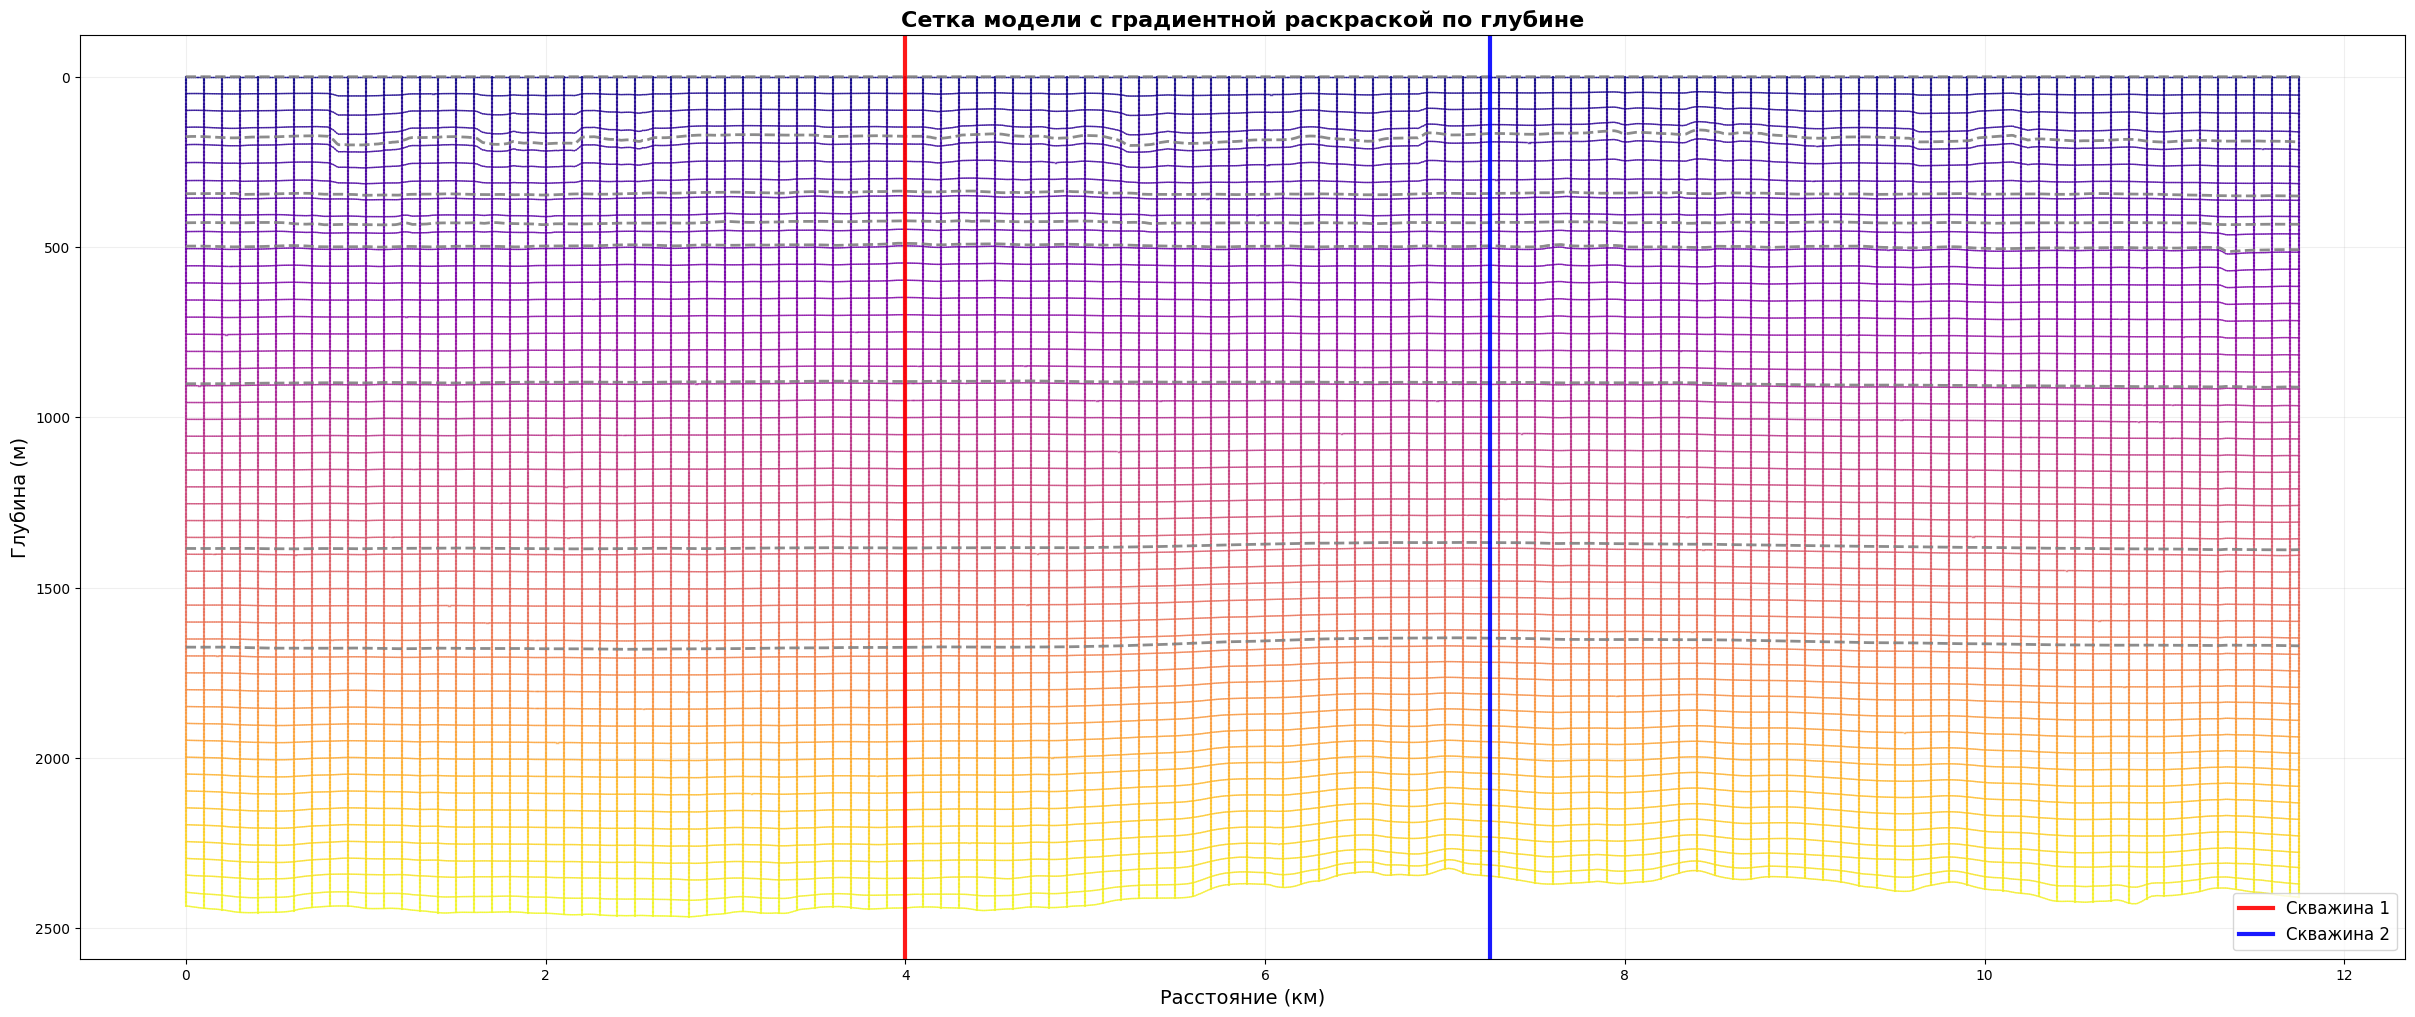

Визуализация структуры сетки сохранена в файл: grid_structure_visualization.png


In [19]:
# Визуализация полученной сетки узлов с градиентом по глубине
def visualize_grid(x_coords, grid_z_coords, grid_params, model_layers):
    """
    Создает визуализацию полученной сетки узлов модели с градиентом цвета по глубине
    """
    fig, ax = plt.subplots(1, 1, figsize=(30, 12))
    
    # Определяем диапазон глубин для нормализации цветов
    min_depth = np.min(grid_z_coords)
    max_depth = np.max(grid_z_coords)
    
    # Используем colormap 'plasma' для красивого градиента по глубине (темно-синий -> фиолетовый -> оранжевый -> желтый)
    colormap = plt.cm.plasma
    
    # Показываем вертикальные линии сетки с градиентом
    sample_indices = list(range(0, len(x_coords), 10)) + [-1]  # Каждая 10-я линия для читаемости
    
    for i in sample_indices:
        if i >= len(x_coords):
            i = len(x_coords) - 1
        
        z_profile = grid_z_coords[i, :]
        x_pos = x_coords[i] / 1000  # в км
        
        # Рисуем каждый сегмент линии с цветом, соответствующим глубине
        for j in range(len(z_profile) - 1):
            depth_mid = (z_profile[j] + z_profile[j+1]) / 2
            normalized_depth = (depth_mid - min_depth) / (max_depth - min_depth)
            color = colormap(normalized_depth)
            
            ax.plot([x_pos, x_pos], [z_profile[j], z_profile[j+1]], 
                   color=color, linewidth=1.5, alpha=0.8)
    
    # Показываем горизонтальные линии сетки с градиентом
    sample_depths_indices = list(range(0, grid_z_coords.shape[1], 5)) + [-1]  # Каждая 5-я горизонтальная линия
    
    for j_idx in sample_depths_indices:
        if j_idx < grid_z_coords.shape[1]:
            z_line = grid_z_coords[:, j_idx]
            x_line = x_coords / 1000
            
            # Рисуем каждый сегмент горизонтальной линии с цветом по глубине
            for i in range(len(z_line) - 1):
                depth_mid = (z_line[i] + z_line[i+1]) / 2
                normalized_depth = (depth_mid - min_depth) / (max_depth - min_depth)
                color = colormap(normalized_depth)
                
                ax.plot([x_line[i], x_line[i+1]], [z_line[i], z_line[i+1]], 
                       color=color, linewidth=1, alpha=0.7)
    
    # Показываем основные границы поверхностей серыми пунктирными линиями
    important_layers = [layer for i, layer in enumerate(model_layers) if i < 8]  # Первые 8 слоев
    for layer in important_layers:
        if layer['bottom_surface'] and layer['bottom_surface'] in profile_depths:
            surface_depths = profile_depths[layer['bottom_surface']]
            profile_x = profile_grid['distances'] / 1000
            ax.plot(profile_x, surface_depths, '--', color='gray', linewidth=2, alpha=0.9)
    
    # Отметим позиции скважин красными и синими вертикальными линиями
    well1_pos_km = grid_params['well1_x_pos'] / 1000
    well2_pos_km = grid_params['well2_x_pos'] / 1000
    
    ax.axvline(x=well1_pos_km, color='red', linestyle='-', linewidth=3, alpha=0.9, label='Скважина 1')
    ax.axvline(x=well2_pos_km, color='blue', linestyle='-', linewidth=3, alpha=0.9, label='Скважина 2')
    
    # Настройки графика
    ax.set_xlabel('Расстояние (км)', fontsize=14)
    ax.set_ylabel('Глубина (м)', fontsize=14)
    ax.set_title('Сетка модели с градиентной раскраской по глубине', fontsize=16, weight='bold')
    ax.grid(True, alpha=0.2)
    ax.invert_yaxis()  # Глубина увеличивается вниз
    ax.legend(fontsize=12)
    
    # Добавляем цветовую шкалу
    # sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=min_depth, vmax=max_depth))
    # sm.set_array([])
    # cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
    # cbar.set_label('Глубина (м)', fontsize=12)
    
    # plt.tight_layout()
    
    # Сохраняем график
    output_filename = 'grid_structure_visualization.png'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    if SHOW_PLOTS:
        plt.show()
    else:
        plt.close()
    
    return output_filename

# Визуализируем сетку с новым градиентом
vis_file = visualize_grid(grid_params['x_coords'], grid_z_coords, grid_params, model_layers)
print(f"Визуализация структуры сетки сохранена в файл: {vis_file}")


In [20]:
# Сохранение итоговых результатов и создание отчета
def save_grid_results(x_coords, grid_z_coords, grid_params, model_layers):
    """
    Сохраняет все результаты построения сетки
    """
    # Основные данные сетки
    grid_data = {
        'x_coordinates': x_coords,  # X-координаты узлов [1176]
        'z_coordinates': grid_z_coords,  # Z-координаты узлов [1176 x 245]
        'grid_nx': grid_params['nx'],
        'grid_nz': grid_params['nz'],
        'dx': grid_params['dx'],
        'dz': grid_params['dz'],
        'well1_x_pos': grid_params['well1_x_pos'],
        'well1_x_index': grid_params['well1_x_index'],
        'well2_x_pos': grid_params['well2_x_pos'],
        'well2_x_index': grid_params['well2_x_index'],
        'z_coords_well1': grid_params['z_coords_well1']
    }
    
    # Информация о слоях
    layer_info = []
    for layer in model_layers:
        layer_info.append({
            'id': layer['id'],
            'name': layer['name'],
            'top_depth': layer['top_depth'],
            'bottom_depth': layer['bottom_depth'],
            'top_surface': layer['top_surface'],
            'bottom_surface': layer['bottom_surface']
        })
    
    grid_data['model_layers'] = layer_info
    
    # Сохраняем в NPZ файл
    grid_file = 'model1_mesh_coords.npz'
    np.savez_compressed(grid_file, **grid_data)
    
    return grid_file

# Сохраняем результаты
grid_file = save_grid_results(grid_params['x_coords'], grid_z_coords, grid_params, model_layers)

# Итоговый отчет
print("="*80)
print("РЕЗУЛЬТАТЫ ПОСТРОЕНИЯ ГЕОМЕТРИИ КОНЕЧНО-ЭЛЕМЕНТНОЙ СЕТКИ")
print("="*80)
print(f"Размер сетки: {grid_params['nx']} × {grid_params['nz']} узлов")
print(f"Общее количество узлов: {grid_params['nx'] * grid_params['nz']:,}")
print(f"Шаг сетки: {grid_params['dx']} × {grid_params['dz']} м")
print()
print("ДИАПАЗОНЫ КООРДИНАТ:")
print(f"X: 0 - {grid_params['x_coords'][-1]:.0f} м")
print(f"Z: {np.min(grid_z_coords):.1f} - {np.max(grid_z_coords):.1f} м")
print()
print("ПОЗИЦИИ СКВАЖИН:")
print(f"Скважина 1: X = {grid_params['well1_x_pos']:.0f} м (индекс {grid_params['well1_x_index']})")
print(f"Скважина 2: X = {grid_params['well2_x_pos']:.0f} м (индекс {grid_params['well2_x_index']})")
print()
print("ГЕОЛОГИЧЕСКИЕ СЛОИ:")
for i, layer in enumerate(model_layers, 1):
    thickness = layer['bottom_depth'] - layer['top_depth']
    print(f"{i:2d}. {layer['name']:<40} {thickness:>8.1f} м")
print()
print("СОЗДАННЫЕ ФАЙЛЫ:")
print(f"- Координаты узлов сетки: {grid_file}")
print(f"- Визуализация структуры: {vis_file}")
print()
print("ПРОВЕРКА КАЧЕСТВА СЕТКИ:")
# Проверяем монотонность в скважине 1
well1_z_profile = grid_z_coords[grid_params['well1_x_index'], :]
z_diffs = np.diff(well1_z_profile)
monotonic = np.all(z_diffs >= 0)
print(f"Монотонность глубин в скважине 1: {'ОК' if monotonic else 'ОШИБКА'}")

# Проверяем максимальные отклонения
max_z_diff = np.max(np.abs(np.diff(grid_z_coords, axis=1)))
print(f"Максимальный градиент между соседними узлами: {max_z_diff:.2f} м")

print("="*80)
print("ПОСТРОЕНИЕ АДАПТИВНОЙ ГЕОМЕТРИИ СЕТКИ ЗАВЕРШЕНО")
print("="*80)


РЕЗУЛЬТАТЫ ПОСТРОЕНИЯ ГЕОМЕТРИИ КОНЕЧНО-ЭЛЕМЕНТНОЙ СЕТКИ
Размер сетки: 1176 × 245 узлов
Общее количество узлов: 288,120
Шаг сетки: 10.0 × 10.0 м

ДИАПАЗОНЫ КООРДИНАТ:
X: 0 - 11750 м
Z: 0.0 - 2466.2 м

ПОЗИЦИИ СКВАЖИН:
Скважина 1: X = 4000 м (индекс 400)
Скважина 2: X = 7250 м (индекс 725)

ГЕОЛОГИЧЕСКИЕ СЛОИ:
 1. Surface_to_0_surf                             0.0 м
 2. 0_surf_to_Under_0                           177.6 м
 3. Under_0_to_Upper                            158.9 м
 4. Upper_to_G2                                  87.6 м
 5. G2_to_G1                                     68.4 м
 6. G1_to_G                                     401.7 м
 7. G_to_M1                                     488.6 м
 8. M1_to_M                                     291.3 м
 9. M_to_B                                      634.1 м
10. B_to_U2                                      43.1 м
11. U2_to_A                                     140.4 м

СОЗДАННЫЕ ФАЙЛЫ:
- Координаты узлов сетки: model1_mesh_coords.npz
- Визу